In [1]:
from __future__ import division
from torchvision import models
from torchvision import transforms
from PIL import Image
import argparse
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torchvision.utils as vutils
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
def load_image(image_path, transform=None, max_size=None, shape=None):
    image = Image.open(image_path)    # 读入图片， 下面是一些图片的预处理操作
    if max_size:
        scale = max_size / max(image.size)
        size= np.array(image.size) * scale
        #print(size)         [400.         306.78733032]
        image = image.resize(size.astype(int), Image.ANTIALIAS)   # 改变图片大小
    
    if shape:
        image = image.resize(shape, Image.LANCZOS)    # Image.LANCZOS是插值的一种方式
        
    if transform:
        #print(image)         # PIL的JpegImageFile格式(size=(W，H))
        image = transform(image).unsqueeze(0)   
        #print(image.shape)   #   [C, H, W] 
    return image.to(device)


transform = transforms.Compose([
    transforms.ToTensor(), #将numpy数组或PIL.Image读的图片转换成(C,H, W)的Tensor格式且/255归一化到[0,1.0]之间
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])      
]) # 来自ImageNet的mean和variance

content = load_image("Bi.jpg", transform, max_size=400)
style = load_image("6.jpg", transform, shape=[content.size(2), content.size(3)])

print(content.shape, style.shape) # torch.Size([1, 3, 306, 400]) torch.Size([1, 3, 400, 306])


torch.Size([1, 3, 400, 400]) torch.Size([1, 3, 400, 400])


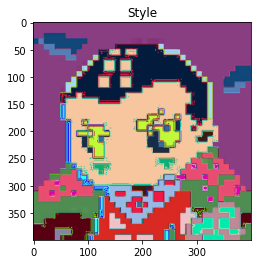

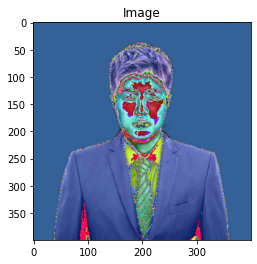

In [3]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style[0], title='Style')
imshow(content[0], title='Image')


In [4]:
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()
        self.select = ['0', '5', '10', '19', '28']   # 这个地方是选择vgg19的某些层出来
        self.vgg = models.vgg19(pretrained=True).features   # 这个地方是拿出vgg19的前面部分， 后面的分类器舍弃掉
        
    def forward(self, x):
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.select:
                features.append(x)
        return features


target = content.clone().requires_grad_(True)
optimizer = torch.optim.Adam([target], lr=0.003, betas=[0.5, 0.999])
vgg = VGGNet().to(device).eval()    # 注意， 这个VGG已经是不训练状态了

In [5]:
total_step = 2000
style_weight = 100.
for step in range(total_step):
    target_features = vgg(target)
    content_features = vgg(content)
    style_features = vgg(style)
    
    style_loss = 0
    content_loss = 0
    for f1, f2, f3 in zip(target_features, content_features, style_features):  # 对于每一层特征， 下面开始计算损失
        content_loss += torch.mean((f1-f2)**2)         # 内容损失
        _, c, h, w = f1.size()  # [c, h, w]
        f1 = f1.view(c, h*w)  #[c, h*w]
        f3 = f3.view(c, h*w)  # [c, h*w]
        
        # 计算gram matrix
        f1 = torch.mm(f1, f1.t())    # [c, c]
        f3 = torch.mm(f3, f3.t())    # [c, c]
        style_loss += torch.mean((f1-f3)**2)/(c*h*w)    # 风格损失
        
    loss = content_loss + style_weight * style_loss  # 总的损失
    
    # 更新target
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if step % 10 == 0:
        print("Step [{}/{}], Content Loss: {:.4f}, Style Loss: {:.4f}"
             .format(step, total_step, content_loss.item(), style_loss.item()))  


Step [0/2000], Content Loss: 0.0000, Style Loss: 1849.4874
Step [10/2000], Content Loss: 7.4186, Style Loss: 1477.5569
Step [20/2000], Content Loss: 19.7657, Style Loss: 988.2571
Step [30/2000], Content Loss: 25.8239, Style Loss: 717.8370
Step [40/2000], Content Loss: 29.4038, Style Loss: 559.8922
Step [50/2000], Content Loss: 31.8628, Style Loss: 458.4152
Step [60/2000], Content Loss: 33.7095, Style Loss: 389.4514
Step [70/2000], Content Loss: 35.1681, Style Loss: 340.3404
Step [80/2000], Content Loss: 36.3435, Style Loss: 303.8705
Step [90/2000], Content Loss: 37.3043, Style Loss: 275.9162
Step [100/2000], Content Loss: 38.0956, Style Loss: 253.9852
Step [110/2000], Content Loss: 38.7694, Style Loss: 236.2198
Step [120/2000], Content Loss: 39.3500, Style Loss: 221.5023
Step [130/2000], Content Loss: 39.8656, Style Loss: 209.1558
Step [140/2000], Content Loss: 40.3174, Style Loss: 198.5924
Step [150/2000], Content Loss: 40.7316, Style Loss: 189.4246
Step [160/2000], Content Loss: 41.1

Step [1360/2000], Content Loss: 49.5118, Style Loss: 43.8062
Step [1370/2000], Content Loss: 49.5319, Style Loss: 43.5279
Step [1380/2000], Content Loss: 49.5594, Style Loss: 43.2560
Step [1390/2000], Content Loss: 49.5802, Style Loss: 42.9886
Step [1400/2000], Content Loss: 49.6085, Style Loss: 42.7234
Step [1410/2000], Content Loss: 49.6293, Style Loss: 42.4606
Step [1420/2000], Content Loss: 49.6486, Style Loss: 42.1983
Step [1430/2000], Content Loss: 49.6776, Style Loss: 41.9402
Step [1440/2000], Content Loss: 49.6977, Style Loss: 41.6806
Step [1450/2000], Content Loss: 49.7201, Style Loss: 41.4267
Step [1460/2000], Content Loss: 49.7444, Style Loss: 41.1698
Step [1470/2000], Content Loss: 49.7661, Style Loss: 40.9199
Step [1480/2000], Content Loss: 49.7872, Style Loss: 40.6714
Step [1490/2000], Content Loss: 49.8125, Style Loss: 40.4226
Step [1500/2000], Content Loss: 49.8398, Style Loss: 40.1791
Step [1510/2000], Content Loss: 49.8598, Style Loss: 39.9337
Step [1520/2000], Conten

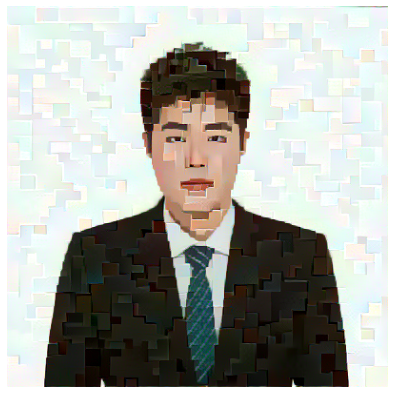

In [6]:
denorm = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))  # 反归一化
img = target.clone().squeeze()
img = denorm(img).clamp_(0, 1)    # 控制到0-1
plt.figure(figsize=(10, 7))
plt.xticks([])  # 去掉x轴
plt.yticks([])  # 去掉y轴
plt.axis('off')  # 去掉坐标轴
imshow(img)

In [7]:
height = 256
height // 2 ** 4

16